In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import datetime as dt
import netCDF4 as cdf
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pylab as plb
from tm5tools import globarea
import calendar
from math import sqrt

In [3]:
##################################### Dataset Definition: Run1 - SiBCASA-GFED4 ###############################################

# co2_rbo_aircraft-pfp_26_representative.nc - Rio Branco
# co2_tab_aircraft-pfp_26_representative.nc - Tabatinga
# co2_san_aircraft-pfp_26_representative.nc - Santarem
# co2_alf_aircraft-pfp_26_representative.nc - Alta Floresta
# co2_mlo_surface-flask_1_representative.nc - Mauna Loa

#directories = ['/Storage/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/',#co2_tab_aircraft-pfp_26_representative.nc',
#              '/Storage/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/', #co2_tab_aircraft-pfp_26_representative.nc',
#              '/Storage/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/',#co2_tab_aircraft-pfp_26_representative.nc',
#              '/Storage/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/',#co2_tab_aircraft-pfp_26_representative.nc',
#              '/Storage/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/' #co2_tab_aircraft-pfp_26_representative.nc'
#              ]

directories = ['/Users/botia/mnt/promise/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/',
              '/Users/botia/mnt/promise/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/', 
              '/Users/botia/mnt/promise/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/',
              '/Users/botia/mnt/promise/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/',
              '/Users/botia/mnt/promise/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/' 
              ]

#legend = ['Observations','SiBCASA-GFED4','GFAS','FINN','CASA-GFED4','CASA-GFED4-3h']

In [4]:
# Root mean square function

def rmse(simulations, observations):
    simulations = np.array(simulations)
    observations = np.array(observations)
    differences = simulations - observations                       #the DIFFERENCEs.
    differences_squared = differences ** 2                    #the SQUAREs of ^
    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^
    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^
    return rmse_val

In [5]:
def marker_size(obs_count,ranges_print = False):
    
    maxx = max(obs_count)
    minn = min(obs_count)
    step = (maxx)/3
    sizes = []
    ranges = [(1,step),(step+1,step*2),(step*2+1,step*3),(step*3+1,maxx)]
    for i in obs_count:
        if 1<i<=step:
            size = 5
            sizes.append(size) 
        
        if step+1 <= i <= step*2:
            size = 7
            sizes.append(size)
        
        if step*2+1 <= i <= maxx:
            size = 9
            sizes.append(size)
        
    if ranges_print:
        return ranges
    return sizes 

In [6]:
# labels generator
def labels_gen(obs_count):
    ranges = marker_size(obs_count,ranges_print = True)
    sizes = marker_size(obs_count,ranges_print = False)
    range1 = range(1,ranges[0][1]+1)
    range2 = range(ranges[0][1]+1,ranges[1][1]+1)
    range3 = range(ranges[1][1]+1,ranges[2][1]+1)
    ranges_all = [range1, range2, range3]
    cont = 0
    labels = []
    for i in obs_count:
        for j in range(len(ranges_all)):
            if i in ranges_all[j]:
                labels.append('%i %s %s %s %i'%(ranges_all[j][0],'<','Obs','<',max(ranges_all[j])))
                cont +=1

    #print set(labels) 
    new_labels = ['']*len(set(labels))
    for num,lab in enumerate(set(labels)):
    #print num, lab
        if str(max(range1)) in lab:
            new_labels[num] = lab
        if str(max(range2)) in lab:
            new_labels[num] = lab
        if str(max(range3)) in lab:
            new_labels[num] = lab
    return new_labels

# this fnmction is not working well
def labels_fitting(l,ss):
    lista = []
    sett = set(ss)
    for i in ss:
        if i == max(sett):
            lista.append(l[0])
        elif i == min(sett):
            lista.append(l[2])
        else:
            lista.append(l[1])
            
    return lista


In [7]:
### Overview of how many obs were done in each 500 m interval from 0-4500 m
### change site 'tab' etc one the name of the co2 file

f_ex = cdf.Dataset('/Users/botia/mnt/promise/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/co2_rbo_aircraft-pfp_26_representative.nc')

alts = f_ex.variables['altitude'][:]
obses = f_ex.variables['value'][:]*1e6               
simus = f_ex.variables['modelsamplesensemble'][:]*1e6
times = f_ex.variables['time_components'][:]

index = np.where(alts<4500)

altura = alts[index] # type numpy array
observs = obses[index]
simulas = simus.sum(axis=1)[index]
alt_sel = set(altura) # type = set 
alt_sel = sorted(alt_sel) # type= list
avg = []
avg_sim = []
obs_bin = []


for h in range(len(alt_sel)):
    obs_same_height = []
    sim_same_height = []
    for i in range(len(altura)):
        if alt_sel[h] == altura[i]:
            obs_same_height.append(observs[i])
            sim_same_height.append(simulas[i])
            
    obs_bin.append(len(obs_same_height))
        #print alt_sel[h], obs_bin

    if alt_sel[h] < 500:
        obs_500 = sum(obs_bin)

    if 500 < alt_sel[h] < 1000:
        obs_1000 = sum(obs_bin)-obs_500

    if 1000 < alt_sel[h] < 1500:
        obs_1500 = sum(obs_bin)-obs_500-obs_1000

    if 1500 < alt_sel[h] < 2000:
        obs_2000 = sum(obs_bin)-obs_500-obs_1000-obs_1500

    if 2000 < alt_sel[h] < 2500:
        obs_2500 = sum(obs_bin)-obs_500-obs_1000-obs_1500-obs_2000

    if 2500 < alt_sel[h] < 3000:
        obs_3000 = sum(obs_bin)-obs_500-obs_1000-obs_1500-obs_2000-obs_2500

    if 3000 < alt_sel[h] < 3500:
        obs_3500 = sum(obs_bin)-obs_500-obs_1000-obs_1500-obs_2000-obs_2500-obs_3000

    if 3500 < alt_sel[h] < 4000:
        obs_4000 = sum(obs_bin)-obs_500-obs_1000-obs_1500-obs_2000-obs_2500-obs_3000-obs_3500

    if 4000 < alt_sel[h] < 4500:
        obs_4500 = sum(obs_bin)-obs_500-obs_1000-obs_1500-obs_2000-obs_2500-obs_3000-obs_3500-obs_4000

print obs_500,obs_1000,obs_1500,obs_2000,obs_2500,obs_3000,obs_3500,obs_4000,obs_4500

74 158 87 169 85 83 89 159 85


0 /Users/botia/mnt/promise/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
['37 < Obs < 54', '19 < Obs < 36'] [35, 56, 37, 37, 31, 26, 31, 38, 24]
['37 < Obs < 54', '19 < Obs < 36']
['23 < Obs < 44', '45 < Obs < 66']
['25 < Obs < 48', '1 < Obs < 24', '49 < Obs < 72']
['23 < Obs < 44', '45 < Obs < 66']
['15 < Obs < 21', '8 < Obs < 14', '1 < Obs < 7']
1 /Users/botia/mnt/promise/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
['37 < Obs < 54', '19 < Obs < 36'] [35, 56, 37, 37, 31, 26, 31, 38, 24]
2 /Users/botia/mnt/promise/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
['37 < Obs < 54', '19 < Obs < 36'] [35, 56, 37, 37, 31, 26, 31, 38, 24]
3 /Users/botia/mnt/promise/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
['37 < Obs < 54', '19 < Obs < 36'] [35, 56, 37, 37, 31, 26, 31, 38, 

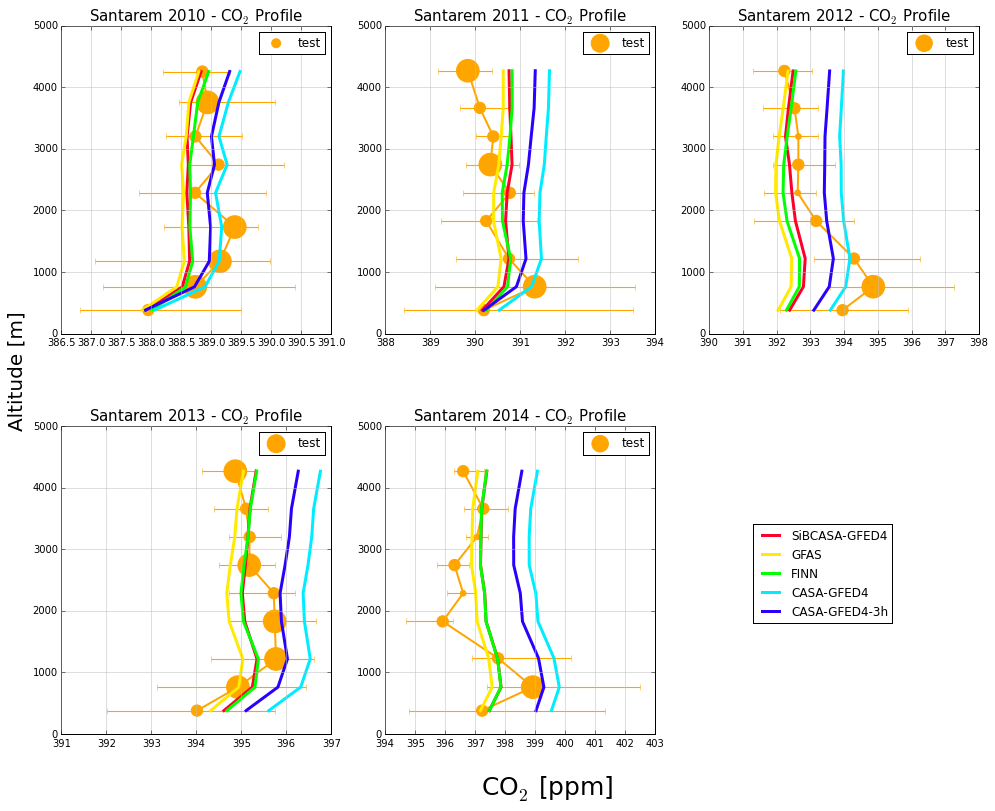

In [52]:
######################################## Santarem: All Products Fire Season
site = 'san'

minyear = 2010
maxyear = 2015

#fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,12))
fig,axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,12))
subplots_adjust(left=0.05, bottom=0.08, right=None, top=None, wspace=None, hspace=0.3)
fig.text(0, 0.5, 'Altitude [m]', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.009, 'CO$_2$ [ppm]', ha='center',fontsize=25)

#altitude = [500,1000,1500,2000,2500,3000,3500,4000,4500]
colors = plt.get_cmap('gist_rainbow')(np.linspace(0,1,6))
legend = ['SiBCASA-GFED4','GFAS','FINN','CASA-GFED4','CASA-GFED4-3h','Observations']

for ii,dirbf in enumerate(directories):
    print ii,dirbf
    for fname in os.listdir(dirbf):
        if fname[4:7] == site:
            print fname
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6               
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            dates = []
            for i in time:
                dates.append(dt.datetime(*i))
            dates = np.array(dates)
                
            for y in range(minyear,maxyear):
                
                # To look at individual years
                date_min = dt.datetime(y,1,1)
                date_max = dt.datetime(y+1,1,1)
                
                # Individual years focusing on fire season, remember to change the maxyear to 2014
                #date_min = dt.datetime(y,8,1)
                #ate_max = dt.datetime(y,12,1)
                
                d_index = np.where(np.logical_and(dates>=date_min,dates<date_max))
                
                # Testing mask inherent to file
                #test_simu = s.sum(axis=1) #[d_index]
                #test_obs  = o[test_simu.mask]
                #new_d_index  = d_index[test_obs]
                #tryt = test_obs[d_index]
                #print shape(test_simu.mask), shape(test_obs), shape(o), shape(d_index), d_index  # shape(new_d_index)
                
                #Original code
                obs = o[d_index]
                sim = s.sum(axis=1)[d_index]
                alt = a[d_index]
        
                index_500 = np.where(alt<500)
                index_1000 = np.where(np.logical_and(alt>=500,alt<1000))
                index_1500 = np.where(np.logical_and(alt>=1000,alt<1500))
                index_2000 = np.where(np.logical_and(alt>=1500,alt<2000))
                index_2500 = np.where(np.logical_and(alt>=2000,alt<2500))
                index_3000 = np.where(np.logical_and(alt>=2500,alt<3000))
                index_3500 = np.where(np.logical_and(alt>=3000,alt<3500))
                index_4000 = np.where(np.logical_and(alt>=3500,alt<4000))
                index_4500 = np.where(np.logical_and(alt>=4000,alt<4500))
                
                indices = [index_500,index_1000,index_1500,index_2000,index_2500,index_3000,
                           index_3500,index_4000,index_4500]    
                
                obs_bin = [len(obs[index_500]), len(obs[index_1000]),  len(obs[index_1500]), 
                           len(obs[index_2000]), len(obs[index_2500]), len(obs[index_3000]),
                           len(obs[index_3500]), len(obs[index_4000]), len(obs[index_4500])]
                
                # activate to see the number of observations in each height per year
                #print y, obs_bin
                
                observations = []
                simulations = []
                error_low = []
                error_high = []
                obs_count = []
                altitude = []
                
                median = []
                upper_quartile = []
                lower_quartile = []
                iqr = []
                upper_whisker = []
                lower_whisker = []
                
                for x in range(len(indices)):
                    simulations.append((sim[indices[x]]).mean())
                    observations.append((obs[indices[x]]).mean())
                    error_low.append(np.median(obs[indices[x]]) - np.percentile(obs[indices[x]],25.0))
                    error_high.append(np.percentile(obs[indices[x]],75.0) - np.median(obs[indices[x]]))
                    obs_count.append(len(obs[indices[x]]))   
                    altitude.append(alt[indices[x]].mean())
                    
                    #try o include whiskers
                    #median.append(np.median(obs[indices[x]]))
                    #upper_quartile.append(np.array(np.percentile(obs[indices[x]], 75)))
                    #lower_quartile.append(np.percentile(obs[indices[x]], 25))
                    #iqr.append(np.percentile(obs[indices[x]], 75) - (np.percentile(obs[indices[x]], 25)))
                    #upper_whisker.append(obs[indices[x]][obs[indices[x]]<=upper_quartile+1.5*iqr].max())
                    #lower_whisker.append(obs[indices[x]][obs[indices[x]]>=lower_quartile-1.5*iqr].min())
                    
                    
                    merged_data = np.concatenate((median,upper_quartile,lower_quartile),0)
                    #print merged_data
                
                if y == 2010: 
                    ax1 = plt.subplot(231)
                    sizes = marker_size(obs_count)
                    ss = [1*2**n for n in sizes]
                    l = labels_gen(obs_count)
                    #lista = labels_fitting(l,ss)
                    print l, obs_count
                    if ii == 0:
                        ax1.scatter(observations, altitude, s=ss, color='orange',label = 'test')
                        ax1.legend(markerscale=0.5,scatterpoints = 1)
                        #a = ax1.scatter(observations, altitude, s=ss, color='orange')
                        #b = ax1.scatter(observations, altitude, s=ss, color='orange')
                        #c = ax1.scatter(observations, altitude, s=ss, color='orange')
                        #ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),color='orange',label=legend[5],linewidth=2,elinewidth=1.1)
                        #ax1.legend((a,b,c),('1','2','3'))

                    #print y, rmse(simulations,observations)
                if y == 2011: 
                    ax1 = plt.subplot(232)
                    sizes = marker_size(obs_count)
                    ss = [1*2**n for n in sizes]
                    if ii == 0:
                        ax1.scatter(observations, altitude, s=ss, color='orange',label = 'test')
                        ax1.legend(scatterpoints = 1)
                    
                    #print y, rmse(simulations,observations)
                if y == 2012: 
                    ax1 = plt.subplot(233)
                    sizes = marker_size(obs_count)
                    ss = [1*2**n for n in sizes]
                    if ii == 0:
                        ax1.scatter(observations, altitude, s=ss, color='orange',label = 'test')
                        ax1.legend(scatterpoints = 1)
                    
                    #print y, rmse(simulations,observations)
                if y == 2013: 
                    ax1 = plt.subplot(234)
                    sizes = marker_size(obs_count)
                    ss = [1*2**n for n in sizes]
                    if ii == 0:
                        ax1.scatter(observations, altitude, s=ss, color='orange',label = 'test')
                        ax1.legend(scatterpoints = 1)
                    
                    #print y, rmse(simulations,observations)
                if y == 2014: 
                    ax1 = plt.subplot(235)
                    sizes = marker_size(obs_count)
                    ss = [1*2**n for n in sizes]
                    if ii == 0:
                        ax1.scatter(observations, altitude, s=ss, color='orange',label = 'test')
                        ax1.legend(scatterpoints = 1)
                    
                    #print y, rmse(simulations,observations)
                
                if ii == 0:
                    l = labels_gen(obs_count)
                    print l
                    #ax1.scatter(observations, altitude, s=ss, color='orange')
                    #for ind in range(len(l)):
                    #    ax1.scatter(observations, altitude, s=ss, color='orange', label=k[ind])
                    ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),color='orange',label=legend[5],linewidth=2,elinewidth=1.1)
                    #ax1.boxplot(merged_data,positions=altitude)
                    #ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),color ='orange',linewidth=2,elinewidth=1.1)
                #print y, sizes, obs_count
                ax1.plot(simulations,altitude,'-',linewidth=3,color=colors[ii],label=legend[ii])
                ax1.set_title('Santarem %i - CO$_2$ Profile'%y,fontsize=15)
                ax1.grid(True, ls='-', color='0.75') # setting the grid and the color on a grey scale
                ax1.set_ylim(0,5000)
            
            ax1 = plt.subplot(236)
            ax1.plot(simulations*0,altitude*0,'-',linewidth=3,color=colors[ii],label=legend[ii])
            ax1.legend(bbox_to_anchor=(0.7, 0.7))
            #ax1.legend(bbox_to_anchor=(2, 0.7))#,scatterpoints = 1)
            ax1.tick_params(axis='x', which='both',bottom='off',top='off',labelbottom='off')
            ax1.tick_params(axis='y', which='both',left='off',right='off',labelleft='off')
            ax1.spines['right'].set_color('none')
            ax1.spines['left'].set_color('none')
            ax1.spines['bottom'].set_color('none')
            ax1.spines['top'].set_color('none') 
    

In [42]:
#boxplot(x, notch=False, sym='+', vert=True, whis=1.5,
#        positions=None, widths=None, patch_artist=False,
#        bootstrap=None, usermedians=None, conf_intervals=None)

#fig,axes = plt.plot(figsize=(15,12))
#fig = plt.plot(figsize=(15,12))

#plt.boxplot(observations[altitude], positions = altitude,vert=False)

#plt.plot(simulations,altitude,'-',linewidth=3)
#print len(observations), len(altitude), observations
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low), 0)

print type(spread),spread

<type 'numpy.ndarray'> [ 27.90563913  98.29835244  27.58725308  56.01016006  20.2946064
  50.32890927  92.90986792  70.72184814  99.74625853  65.09101701
  22.63740421  11.12492801  49.67345423  85.87917145  68.82516514
  63.32420316  15.30798001   2.36862738  35.69570123  58.49628504
  85.97914169  29.89418925  76.30611418  65.50380177  89.35758125
  44.18976824  29.20125453  67.86582876  46.6874547   34.4198933
  77.21520844  47.8631503   69.21212051  14.7097957   66.16132639
  91.4547847    0.52854705   0.12235236  82.16662249  67.592814
  90.42907287  67.62091616  27.84358824  85.41863626   5.35290116
  66.57034528  93.01737245  35.17072618  57.49953313  86.21436021]


In [137]:
simu = s.sum(axis=1)
prueba = o[simu.mask]
obs
print shape(obs), shape(o), shape(prueba)

'''
Ingrids code to put the obs legend
if nobs[i]   < 250:
    n = 0
            c = 'blue'
        elif nobs[i] < 500:
            n = 1
            c = 'green'
        elif nobs[i] < 750:
            n = 2
            c = 'orange'
        elif nobs[i] < 1000:
            n = 3
            c = 'brown'
        else:
            n = 4
            c = 'red'
        if lons[i] > -900:
            x,y = m(lons[i],lats[i])
            ax.plot(x,y,'o',color=c,markersize=12+1.5*n)#,markeredgecolor='k',markeredgewidth=2)
            #ax.annotate(labs[i],xy=m(lons[i],lats[i]),xycoords='data',fontweight='bold')
        else:
            x,y = m(169,87-count)
            ax.plot(x,y,'o',color=c,markersize=12+1.5*n)
            ax.annotate(labs[i],xy=m(172,86-count),xycoords='data',fontweight='bold')
            count = count + 4

    fig.text(0.15,0.945,u'\u2022',fontsize=35,color='blue')
    fig.text(0.16,0.95,': N<250',fontsize=24,color='blue')
    fig.text(0.30,0.94,u'\u2022',fontsize=40,color='green')
    fig.text(0.31,0.95,': N<500',fontsize=24,color='green')
    fig.text(0.45,0.94,u'\u2022',fontsize=45,color='orange')
    fig.text(0.46,0.95,': N<750',fontsize=24,color='orange')
    fig.text(0.60,0.939,u'\u2022',fontsize=50,color='brown')
    fig.text(0.61,0.95,': N<1000',fontsize=24,color='brown')
    fig.text(0.75,0.938,u'\u2022',fontsize=55,color='red')
    fig.text(0.765,0.95,': N>1000',fontsize=24,color='red')
    ax.set_title('Assimilated observations',fontsize=24)'''

(129,) (3124,) (1244,)


"\nIngrids code to put the obs legend\nif nobs[i]   < 250:\n    n = 0\n            c = 'blue'\n        elif nobs[i] < 500:\n            n = 1\n            c = 'green'\n        elif nobs[i] < 750:\n            n = 2\n            c = 'orange'\n        elif nobs[i] < 1000:\n            n = 3\n            c = 'brown'\n        else:\n            n = 4\n            c = 'red'\n        if lons[i] > -900:\n            x,y = m(lons[i],lats[i])\n            ax.plot(x,y,'o',color=c,markersize=12+1.5*n)#,markeredgecolor='k',markeredgewidth=2)\n            #ax.annotate(labs[i],xy=m(lons[i],lats[i]),xycoords='data',fontweight='bold')\n        else:\n            x,y = m(169,87-count)\n            ax.plot(x,y,'o',color=c,markersize=12+1.5*n)\n            ax.annotate(labs[i],xy=m(172,86-count),xycoords='data',fontweight='bold')\n            count = count + 4\n\n    fig.text(0.15,0.945,u'\\u2022',fontsize=35,color='blue')\n    fig.text(0.16,0.95,': N<250',fontsize=24,color='blue')\n    fig.text(0.30,0.94

In [13]:
#z = [d.date() for d in dates]
##check sort
#for date in sorted(set(z)):
    
#    index = [i for i,d in enumerate(dates) if d.date()==date]
    #print date, index
#print dates[index], o[index] #len(set(z)), len(z)
perc25 = np.percentile(observations,25.0)
perc75 = np.percentile(observations,75.0)
median = np.median(observations)
maxx = max(observations)
minn = min(observations)

print perc25, median, perc75, maxx, minn

396.598571777 397.057 397.269989014 398.919 395.916


0 /Users/botia/mnt/promise/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
1 /Users/botia/mnt/promise/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
2 /Users/botia/mnt/promise/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
3 /Users/botia/mnt/promise/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
4 /Users/botia/mnt/promise/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc


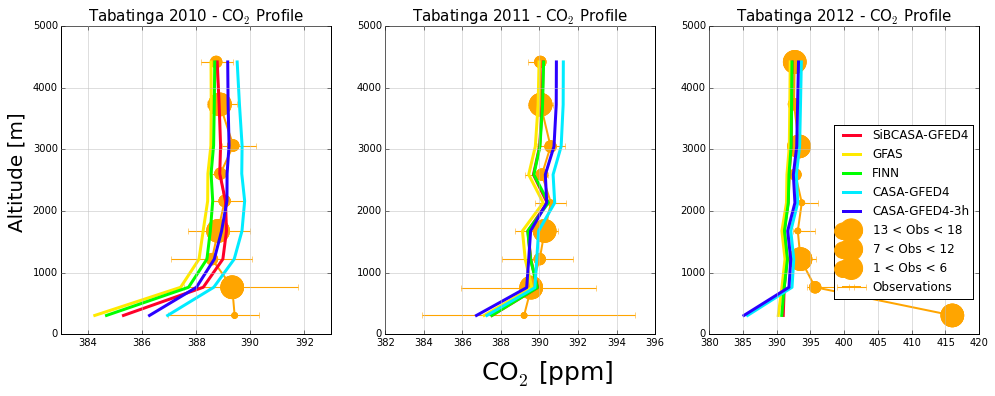

In [81]:
############ Tabatinga all products Fire season

site = 'tab'

minyear = 2010
maxyear = 2013

fig,axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,12))
subplots_adjust(left=0.05, bottom=0.08, right=None, top=None, wspace=None, hspace=0.3)
fig.text(0, 0.73, 'Altitude [m]', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.49, 'CO$_2$ [ppm]', ha='center',fontsize=25)

#altitude = [500,1000,1500,2000,2500,3000,3500,4000,4500]

for ii,dirbf in enumerate(directories):
    print ii,dirbf
    for fname in os.listdir(dirbf):
        if fname[4:7] == site:
            print fname
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6               
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            
            dates = []
            for i in time:
                dates.append(dt.datetime(*i))
            dates = np.array(dates)
            
            for y in range(minyear,maxyear):
                
                # To look at individual years
                date_min = dt.datetime(y,1,1)
                date_max = dt.datetime(y+1,1,1)
                
                # Individual years focusing on fire season
                #date_min = dt.datetime(y,8,1)
                #date_max = dt.datetime(y,12,1)
                
                d_index = np.where(np.logical_and(dates>=date_min,dates<date_max))
                
                obs = o[d_index]
                sim = s.sum(axis=1)[d_index]
                alt = a[d_index]
                
                index_500 = np.where(alt<500)
                index_1000 = np.where(np.logical_and(alt>=500,alt<1000))
                index_1500 = np.where(np.logical_and(alt>=1000,alt<1500))
                index_2000 = np.where(np.logical_and(alt>=1500,alt<2000))
                index_2500 = np.where(np.logical_and(alt>=2000,alt<2500))
                index_3000 = np.where(np.logical_and(alt>=2500,alt<3000))
                index_3500 = np.where(np.logical_and(alt>=3000,alt<3500))
                index_4000 = np.where(np.logical_and(alt>=3500,alt<4000))
                index_4500 = np.where(np.logical_and(alt>=4000,alt<4500))
                
                indices = [index_500,index_1000,index_1500,index_2000,index_2500,index_3000,
                           index_3500,index_4000,index_4500]    
                
                obs_bin = [len(obs[index_500]), len(obs[index_1000]),  len(obs[index_1500]), 
                           len(obs[index_2000]), len(obs[index_2500]), len(obs[index_3000]),
                           len(obs[index_3500]), len(obs[index_4000]), len(obs[index_4500])]
                
                # activate to see the number of observations in each height per year
                #print y, obs_bin
                
                observations = []
                simulations = []
                error_low = []
                error_high = []
                obs_count = []
                altitude = []
                
                for j in range(len(indices)):
                    simulations.append((sim[indices[j]]).mean())
                    observations.append((obs[indices[j]]).mean())
                    error_low.append(np.median(obs[indices[j]]) - np.percentile(obs[indices[j]],25.0))
                    error_high.append(np.percentile(obs[indices[j]],75.0) - np.median(obs[indices[j]]))
                    obs_count.append(len(obs[indices[j]]))   
                    altitude.append(alt[indices[j]].mean())
                    
                if y == 2010: 
                    ax1 = plt.subplot(231)
                    #print y, rmse(simulations,observations)
                if y == 2011: 
                    ax1 = plt.subplot(232)
                    #print y, rmse(simulations,observations)
                if y == 2012: 
                    ax1 = plt.subplot(233)
                    #print y, rmse(simulations,observations)
                if y == 2013: 
                    ax1 = plt.subplot(234)
                    #print y, rmse(simulations,observations)
                if y == 2014: 
                    ax1 = plt.subplot(235)
                    #print y, rmse(simulations,observations)
                if ii == 0:
                    sizes = marker_size(obs_count)
                    l = labels_gen(obs_count)
                    ss = [1*2**n for n in sizes]
                    # i need to connect the size with the label #############
                    for ind in range(len(l)):
                        ax1.scatter(observations, altitude, s=ss, color='orange', label=l[ind])
                    ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),color='orange',label=legend[5],linewidth=2,elinewidth=1.1)
                    #ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),fmt='-o',linewidth=2,markersize=8,elinewidth=1.1)
                #print y, sizes, obs_count
                ax1.plot(simulations,altitude,'-',linewidth=3,color=colors[ii],label=legend[ii])
                ax1.set_title('Tabatinga %i - CO$_2$ Profile'%y,fontsize=15)
                ax1.grid(True, ls='-', color='0.75') # setting the grid and the color on a grey scale
                ax1.set_ylim(0,5000)
            
            #ax1 = plt.subplot(236)
            ax1.legend(bbox_to_anchor=(1, 0.7))
            #ax1.tick_params(axis='x', which='both',bottom='off',top='off',labelbottom='off')
            #ax1.tick_params(axis='y', which='both',left='off',right='off',labelleft='off')
            #ax1.spines['right'].set_color('none')
            #ax1.spines['left'].set_color('none')
            #ax1.spines['bottom'].set_color('none')
            #ax1.spines['top'].set_color('none')

    ##ax6.legend(legend[:],loc='lower left', bbox_to_anchor=(1, 1.2))
    #leg = plt.gca().get_legend()
    #ltext  = leg.get_texts()
    #plt.setp(ltext, fontsize='23') 

0 /Users/botia/mnt/promise/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
1 /Users/botia/mnt/promise/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
2 /Users/botia/mnt/promise/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
3 /Users/botia/mnt/promise/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
4 /Users/botia/mnt/promise/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc


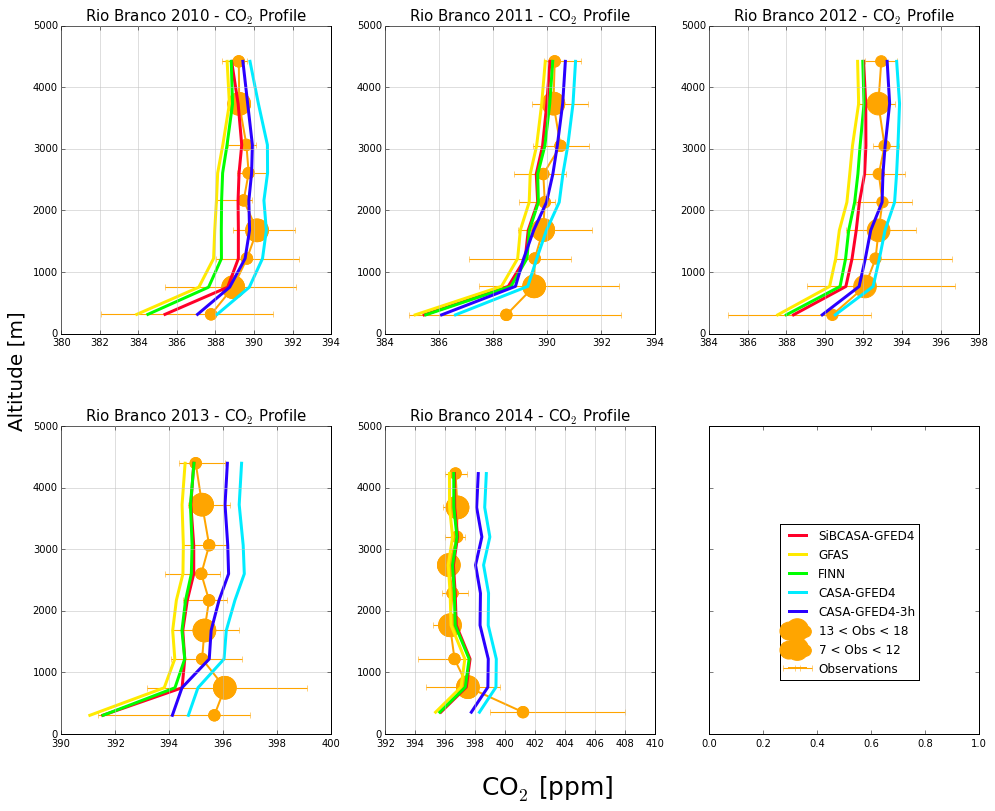

In [190]:
###################### Rio Branco all products
site = 'rbo'

minyear = 2010
maxyear = 2015

fig,axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,12))
subplots_adjust(left=0.05, bottom=0.08, right=None, top=None, wspace=None, hspace=0.3)
fig.text(0, 0.5, 'Altitude [m]', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.009, 'CO$_2$ [ppm]', ha='center',fontsize=25)

#altitude = [500,1000,1500,2000,2500,3000,3500,4000,4500]

for ii,dirbf in enumerate(directories):
    print ii,dirbf
    for fname in os.listdir(dirbf):
        if fname[4:7] == site:
            print fname
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6               
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            
            dates = []
            for i in time:
                dates.append(dt.datetime(*i))
            dates = np.array(dates)
            
            for y in range(minyear,maxyear):
                
                # To look at individual years
                date_min = dt.datetime(y,1,1)
                date_max = dt.datetime(y+1,1,1)
                
                # Individual years focusing on fire season
                #date_min = dt.datetime(y,8,1)
                #date_max = dt.datetime(y,12,1)
                
                d_index = np.where(np.logical_and(dates>=date_min,dates<date_max))
                
                obs = o[d_index]
                sim = s.sum(axis=1)[d_index]
                alt = a[d_index]
                
                index_500 = np.where(alt<500)
                index_1000 = np.where(np.logical_and(alt>=500,alt<1000))
                index_1500 = np.where(np.logical_and(alt>=1000,alt<1500))
                index_2000 = np.where(np.logical_and(alt>=1500,alt<2000))
                index_2500 = np.where(np.logical_and(alt>=2000,alt<2500))
                index_3000 = np.where(np.logical_and(alt>=2500,alt<3000))
                index_3500 = np.where(np.logical_and(alt>=3000,alt<3500))
                index_4000 = np.where(np.logical_and(alt>=3500,alt<4000))
                index_4500 = np.where(np.logical_and(alt>=4000,alt<4500))
                
                indices = [index_500,index_1000,index_1500,index_2000,index_2500,index_3000,
                           index_3500,index_4000,index_4500]    
                
                obs_bin = [len(obs[index_500]), len(obs[index_1000]),  len(obs[index_1500]), 
                           len(obs[index_2000]), len(obs[index_2500]), len(obs[index_3000]),
                           len(obs[index_3500]), len(obs[index_4000]), len(obs[index_4500])]
                
                # activate to see the number of observations in each height per year
                #print y, obs_bin
                
                observations = []
                simulations = []
                error_low = []
                error_high = []
                obs_count = []
                altitude = []
                
                for j in range(len(indices)):
                    simulations.append((sim[indices[j]]).mean())
                    observations.append((obs[indices[j]]).mean())
                    error_low.append(np.median(obs[indices[j]]) - np.percentile(obs[indices[j]],25.0))
                    error_high.append(np.percentile(obs[indices[j]],75.0) - np.median(obs[indices[j]]))
                    obs_count.append(len(obs[indices[j]]))   
                    altitude.append(alt[indices[j]].mean())
                    
                if y == 2010: 
                    ax1 = plt.subplot(231)
                    #print y, rmse(simulations,observations)
                if y == 2011: 
                    ax1 = plt.subplot(232)
                    #print y, rmse(simulations,observations)
                if y == 2012: 
                    ax1 = plt.subplot(233)
                    #print y, rmse(simulations,observations)
                if y == 2013: 
                    ax1 = plt.subplot(234)
                    #print y, rmse(simulations,observations)
                if y == 2014: 
                    ax1 = plt.subplot(235)
                    #print y, rmse(simulations,observations)
                if ii == 0:
                    sizes = marker_size(obs_count)
                    l = labels_gen(obs_count)
                    ss = [1*2**n for n in sizes]
                    # i need to connect the size with the label #############
                    for ind in range(len(l)):
                        ax1.scatter(observations, altitude, s=ss, color='orange', label=l[ind])
                    ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),color='orange',label=legend[5],linewidth=2,elinewidth=1.1)
                    #ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),fmt='-o',linewidth=2,markersize=8,elinewidth=1.1)
                #print y, sizes, obs_count
                ax1.plot(simulations,altitude,'-',linewidth=3,color=colors[ii],label=legend[ii])
                ax1.set_title('Rio Branco %i - CO$_2$ Profile'%y,fontsize=15)
                ax1.grid(True, ls='-', color='0.75') # setting the grid and the color on a grey scale
                ax1.set_ylim(0,5000)
            
            #ax1 = plt.subplot(236)
            ax1.legend(bbox_to_anchor=(2, 0.7))
            #ax1.tick_params(axis='x', which='both',bottom='off',top='off',labelbottom='off')
            #ax1.tick_params(axis='y', which='both',left='off',right='off',labelleft='off')
            #ax1.spines['right'].set_color('none')
            #ax1.spines['left'].set_color('none')
            #ax1.spines['bottom'].set_color('none')
            #ax1.spines['top'].set_color('none')

    ##ax6.legend(legend[:],loc='lower left', bbox_to_anchor=(1, 1.2))
    #leg = plt.gca().get_legend()
    #ltext  = leg.get_texts()
    #plt.setp(ltext, fontsize='23') 
    

0 /Users/botia/mnt/promise/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
1 /Users/botia/mnt/promise/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
2 /Users/botia/mnt/promise/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
3 /Users/botia/mnt/promise/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
4 /Users/botia/mnt/promise/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc


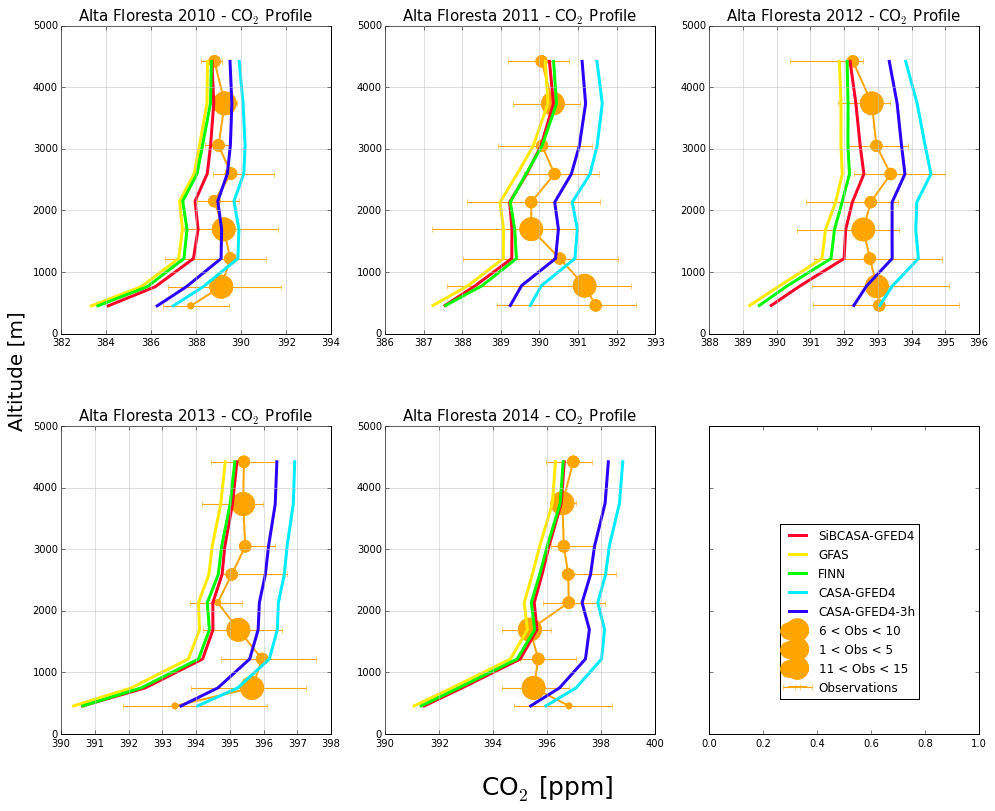

In [191]:
################################# Alta Floresta all products
site = 'alf'

minyear = 2010
maxyear = 2015

fig,axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,12))
subplots_adjust(left=0.05, bottom=0.08, right=None, top=None, wspace=None, hspace=0.3)
fig.text(0, 0.5, 'Altitude [m]', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.009, 'CO$_2$ [ppm]', ha='center',fontsize=25)

#altitude = [500,1000,1500,2000,2500,3000,3500,4000,4500]

for ii,dirbf in enumerate(directories):
    print ii,dirbf
    for fname in os.listdir(dirbf):
        if fname[4:7] == site:
            print fname
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6               
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            
            dates = []
            for i in time:
                dates.append(dt.datetime(*i))
            dates = np.array(dates)
            
            for y in range(minyear,maxyear):
                
                # To look at individual years
                date_min = dt.datetime(y,1,1)
                date_max = dt.datetime(y+1,1,1)
                
                # Individual years focusing on fire season
                #date_min = dt.datetime(y,8,1)
                #date_max = dt.datetime(y,12,1)
                
                d_index = np.where(np.logical_and(dates>=date_min,dates<date_max))
                
                obs = o[d_index]
                sim = s.sum(axis=1)[d_index]
                alt = a[d_index]
                
                index_500 = np.where(alt<500)
                index_1000 = np.where(np.logical_and(alt>=500,alt<1000))
                index_1500 = np.where(np.logical_and(alt>=1000,alt<1500))
                index_2000 = np.where(np.logical_and(alt>=1500,alt<2000))
                index_2500 = np.where(np.logical_and(alt>=2000,alt<2500))
                index_3000 = np.where(np.logical_and(alt>=2500,alt<3000))
                index_3500 = np.where(np.logical_and(alt>=3000,alt<3500))
                index_4000 = np.where(np.logical_and(alt>=3500,alt<4000))
                index_4500 = np.where(np.logical_and(alt>=4000,alt<4500))
                
                indices = [index_500,index_1000,index_1500,index_2000,index_2500,index_3000,
                           index_3500,index_4000,index_4500]    
                
                obs_bin = [len(obs[index_500]), len(obs[index_1000]),  len(obs[index_1500]), 
                           len(obs[index_2000]), len(obs[index_2500]), len(obs[index_3000]),
                           len(obs[index_3500]), len(obs[index_4000]), len(obs[index_4500])]
                
                # activate to see the number of observations in each height per year
                #print y, obs_bin
                
                observations = []
                simulations = []
                error_low = []
                error_high = []
                obs_count = []
                altitude = []
                
                for j in range(len(indices)):
                    altitude.append(alt[indices[j]].mean())
                    simulations.append((sim[indices[j]]).mean())
                    observations.append((obs[indices[j]]).mean())
                    obs_count.append(len(obs[indices[j]]))
                    if obs_bin[j] !=0:
                        error_low.append(np.median(obs[indices[j]]) - np.percentile(obs[indices[j]],25.0))
                        error_high.append(np.percentile(obs[indices[j]],75.0) - np.median(obs[indices[j]]))
                    else:
                        error_low.insert(0,0)
                        error_high.insert(0,0)
                
                if y == 2010: 
                    ax1 = plt.subplot(231)
                    #print y, rmse(simulations,observations)
                if y == 2011: 
                    ax1 = plt.subplot(232)
                    #print y, rmse(simulations,observations)
                if y == 2012: 
                    ax1 = plt.subplot(233)
                    #print y, rmse(simulations,observations)
                if y == 2013: 
                    ax1 = plt.subplot(234)
                    #print y, rmse(simulations,observations)
                if y == 2014: 
                    ax1 = plt.subplot(235)
                    #print y, rmse(simulations,observations)
                if ii == 0:
                    sizes = marker_size(obs_count)
                    l = labels_gen(obs_count)
                    ss = [1*2**n for n in sizes]
                    # i need to connect the size with the label #############
                    for ind in range(len(l)):
                        ax1.scatter(observations, altitude, s=ss, color='orange', label=l[ind])
                    ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),color='orange',label=legend[5],linewidth=2,elinewidth=1.1)
                    #ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),fmt='-o',linewidth=2,markersize=8,elinewidth=1.1)
                #print y, sizes, obs_count
                ax1.plot(simulations,altitude,'-',linewidth=3,color=colors[ii],label=legend[ii])
                ax1.set_title('Alta Floresta %i - CO$_2$ Profile'%y,fontsize=15)
                ax1.grid(True, ls='-', color='0.75') # setting the grid and the color on a grey scale
                ax1.set_ylim(0,5000)
            
            #ax1 = plt.subplot(236)
            ax1.legend(bbox_to_anchor=(2, 0.7))
            #ax1.tick_params(axis='x', which='both',bottom='off',top='off',labelbottom='off')
            #ax1.tick_params(axis='y', which='both',left='off',right='off',labelleft='off')
            #ax1.spines['right'].set_color('none')
            #ax1.spines['left'].set_color('none')
            #ax1.spines['bottom'].set_color('none')
            #ax1.spines['top'].set_color('none')

    ##ax6.legend(legend[:],loc='lower left', bbox_to_anchor=(1, 1.2))
    #leg = plt.gca().get_legend()
    #ltext  = leg.get_texts()
    #plt.setp(ltext, fontsize='23') 
    

0 /Users/botia/mnt/promise/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
TAB:SiBCASA-GFED4 RMSE =  1.59776
1 /Users/botia/mnt/promise/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
TAB:GFAS RMSE =  1.99768
2 /Users/botia/mnt/promise/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
TAB:FINN-GFED4 RMSE =  1.78137
3 /Users/botia/mnt/promise/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
TAB:CASA-GFED4 RMSE =  1.44726
4 /Users/botia/mnt/promise/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/
co2_tab_aircraft-pfp_26_representative.nc
TAB:CASA-GFED4-3h RMSE =  1.6326


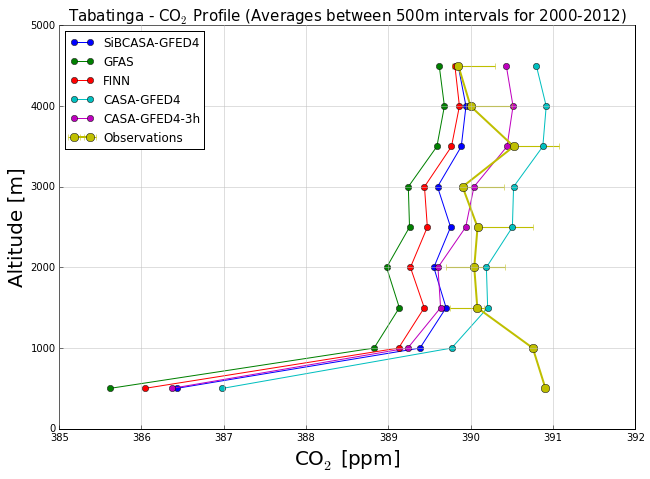

In [17]:
######################################## Tabatinga all the dataset
site = 'tab'

fig = plt.figure(1,figsize=(10,8))
ax1 = fig.add_axes([0.1,0.2,0.8,0.7])
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')

altitude = [500,1000,1500,2000,2500,3000,3500,4000,4500]
legend=['SiBCASA-GFED4','GFAS','FINN','CASA-GFED4','CASA-GFED4-3h', 'Observations']

for ii,dirbf in enumerate(directories):
    print ii,dirbf
    #for y in range(minyear,maxyear):
    for fname in os.listdir(dirbf):
        if fname[4:7] == site:
            print fname
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6               
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            # indices to group per altitude 
            
            index_500 = np.where(a<500)
            index_1000 = np.where(np.logical_and(a>=500,a<1000))
            index_1500 = np.where(np.logical_and(a>=1000,a<1500))
            index_2000 = np.where(np.logical_and(a>=1500,a<2000))
            index_2500 = np.where(np.logical_and(a>=2000,a<2500))
            index_3000 = np.where(np.logical_and(a>=2500,a<3000))
            index_3500 = np.where(np.logical_and(a>=3000,a<3500))
            index_4000 = np.where(np.logical_and(a>=3500,a<4000))
            index_4500 = np.where(np.logical_and(a>=4000,a<4500))
            
            indices = [index_500,index_1000,index_1500,index_2000,index_2500,index_3000,
                       index_3500,index_4000,index_4500]
            
            observations = []
            simulations = []
            error_low = []
            error_high = []
            
            for i in range(len(indices)):
                observations.append((o[indices[i]]).mean())
                simulations.append((s.sum(axis=1)[indices[i]]).mean())
                error_low.append(np.median(observations) - np.percentile(observations,25.0))
                error_high.append(np.percentile(observations,75.0) - np.median(observations))
            
            if ii == 0:
                print 'TAB:SiBCASA-GFED4 RMSE = ', rmse(simulations,observations)
                
            if ii == 1:
                print 'TAB:GFAS RMSE = ', rmse(simulations,observations)
            
            if ii == 2:
                print 'TAB:FINN-GFED4 RMSE = ', rmse(simulations,observations)
            
            if ii == 3:
                print 'TAB:CASA-GFED4 RMSE = ', rmse(simulations,observations)
                
            if ii == 4:
                print 'TAB:CASA-GFED4-3h RMSE = ', rmse(simulations,observations)
                  
    
    ax1.plot(simulations,altitude,'-o',label=legend[ii])
    
ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),fmt='-o',label=legend[5],linewidth=2,markersize=8,elinewidth=1.1)
#ax1.errorbar(observations,altitude,'-',label=legend[5])
ax1.set_ylim(0,5000)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
ax1.set_title('Tabatinga - CO$_2$ Profile (Averages between 500m intervals for 2000-2012)',fontsize=15)
ax1.grid(True, ls='-', color='0.75') # setting the grid and the color on a grey scale
ax1.set_xlabel('CO$_2$ [ppm]',fontsize=20)
ax1.set_ylabel('Altitude [m]',fontsize=20)
ax1.legend(loc='upper left')

0 /Storage/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
RBO:SiBCASA-GFED4 RMSE =  1.15903
1 /Storage/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
RBO:GFAS RMSE =  1.66151
2 /Storage/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
RBO:FINN-GFED4 RMSE =  1.35693
3 /Storage/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
RBO:CASA-GFED4 RMSE =  0.924526
4 /Storage/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/
co2_rbo_aircraft-pfp_26_representative.nc
RBO:CASA-GFED4-3h RMSE =  0.647671


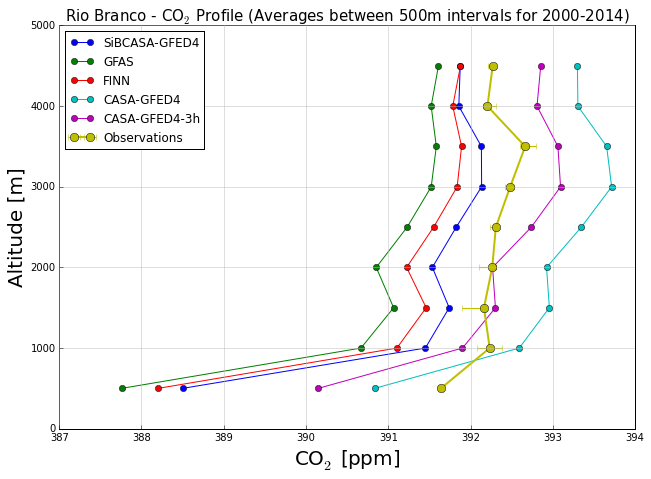

In [41]:
######################################## Rio Branco all dataset
site = 'rbo'

fig = plt.figure(1,figsize=(10,8))
ax1 = fig.add_axes([0.1,0.2,0.8,0.7])
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
#subplots_adjust(left=0.05, bottom=0.08, right=None, top=None, wspace=None, hspace=0.3)
#fig.text(0.5, 0.009, 'Observations vs Simulations - Santarem', ha='center',fontsize=13)
#fig.text(0, 0.5, 'CO$_2$ concentration ppm', va='center', rotation='vertical',fontsize=13)

altitude = [500,1000,1500,2000,2500,3000,3500,4000,4500]
legend=['SiBCASA-GFED4','GFAS','FINN','CASA-GFED4','CASA-GFED4-3h', 'Observations']
for ii,dirbf in enumerate(directories):
    print ii,dirbf
    #for y in range(minyear,maxyear):
    for fname in os.listdir(dirbf):
        if fname[4:7] == site:
            print fname
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6               
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            # indices to group per altitude 
            
            index_500 = np.where(a<500)
            index_1000 = np.where(np.logical_and(a>=500,a<1000))
            index_1500 = np.where(np.logical_and(a>=1000,a<1500))
            index_2000 = np.where(np.logical_and(a>=1500,a<2000))
            index_2500 = np.where(np.logical_and(a>=2000,a<2500))
            index_3000 = np.where(np.logical_and(a>=2500,a<3000))
            index_3500 = np.where(np.logical_and(a>=3000,a<3500))
            index_4000 = np.where(np.logical_and(a>=3500,a<4000))
            index_4500 = np.where(np.logical_and(a>=4000,a<4500))
            
            indices = [index_500,index_1000,index_1500,index_2000,index_2500,index_3000,
                       index_3500,index_4000,index_4500]
            observations = []
            simulations = []
            error_low = []
            error_high = []
            
            for i in range(len(indices)):
                observations.append((o[indices[i]]).mean())
                simulations.append((s.sum(axis=1)[indices[i]]).mean())
                error_low.append(np.median(observations) - np.percentile(observations,25.0))
                error_high.append(np.percentile(observations,75.0) - np.median(observations))
            
            if ii == 0:
                print 'RBO:SiBCASA-GFED4 RMSE = ', rmse(simulations,observations)
                
            if ii == 1:
                print 'RBO:GFAS RMSE = ', rmse(simulations,observations)
            
            if ii == 2:
                print 'RBO:FINN-GFED4 RMSE = ', rmse(simulations,observations)
            
            if ii == 3:
                print 'RBO:CASA-GFED4 RMSE = ', rmse(simulations,observations)
                
            if ii == 4:
                print 'RBO:CASA-GFED4-3h RMSE = ', rmse(simulations,observations)
                
    ax1.plot(simulations,altitude,'-o',label=legend[ii])
ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),fmt='-o',label=legend[5],linewidth=2,markersize=8,elinewidth=1.1)
#ax1.errorbar(observations,altitude,'-',label=legend[5])
ax1.set_ylim(0,5000)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
ax1.set_title('Rio Branco - CO$_2$ Profile (Averages between 500m intervals for 2000-2014)',fontsize=15)
ax1.grid(True, ls='-', color='0.75') # setting the grid and the color on a grey scale
ax1.set_xlabel('CO$_2$ [ppm]',fontsize=20)
ax1.set_ylabel('Altitude [m]',fontsize=20)
ax1.legend(loc='upper left')

0 /Storage/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
ALF:SiBCASA-GFED4 RMSE =  1.61355
1 /Storage/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
ALF:GFAS RMSE =  1.97518
2 /Storage/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
ALF:FINN-GFED4 RMSE =  1.76814
3 /Storage/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
ALF:CASA-GFED4 RMSE =  1.10825
4 /Storage/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/
co2_alf_aircraft-pfp_26_representative.nc
ALF:CASA-GFED4-3h RMSE =  0.768604


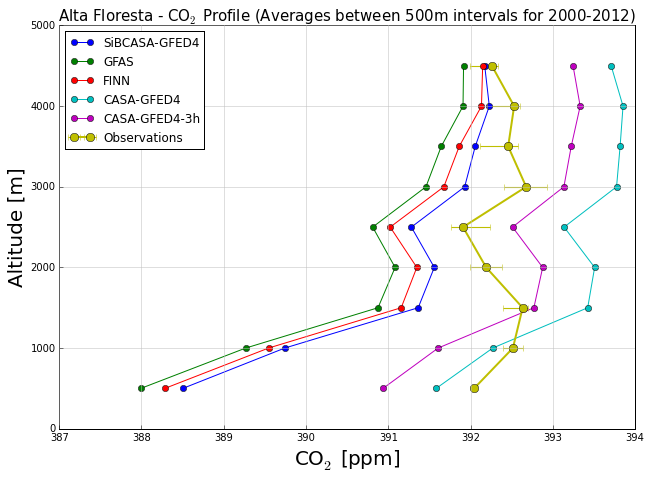

In [42]:
######################################## Alta Floresta all dataset
site = 'alf'

fig = plt.figure(1,figsize=(10,8))
ax1 = fig.add_axes([0.1,0.2,0.8,0.7])
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
#subplots_adjust(left=0.05, bottom=0.08, right=None, top=None, wspace=None, hspace=0.3)
#fig.text(0.5, 0.009, 'Observations vs Simulations - Santarem', ha='center',fontsize=13)
#fig.text(0, 0.5, 'CO$_2$ concentration ppm', va='center', rotation='vertical',fontsize=13)

altitude = [500,1000,1500,2000,2500,3000,3500,4000,4500]
legend=['SiBCASA-GFED4','GFAS','FINN','CASA-GFED4','CASA-GFED4-3h', 'Observations']
for ii,dirbf in enumerate(directories):
    print ii,dirbf
    #for y in range(minyear,maxyear):
    for fname in os.listdir(dirbf):
        if fname[4:7] == site:
            print fname
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6               
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            # indices to group per altitude 
            
            index_500 = np.where(a<500)
            index_1000 = np.where(np.logical_and(a>=500,a<1000))
            index_1500 = np.where(np.logical_and(a>=1000,a<1500))
            index_2000 = np.where(np.logical_and(a>=1500,a<2000))
            index_2500 = np.where(np.logical_and(a>=2000,a<2500))
            index_3000 = np.where(np.logical_and(a>=2500,a<3000))
            index_3500 = np.where(np.logical_and(a>=3000,a<3500))
            index_4000 = np.where(np.logical_and(a>=3500,a<4000))
            index_4500 = np.where(np.logical_and(a>=4000,a<4500))
            
            indices = [index_500,index_1000,index_1500,index_2000,index_2500,index_3000,
                       index_3500,index_4000,index_4500]
            observations = []
            simulations = []
            error_low = []
            error_high = []
            
            for i in range(len(indices)):
                observations.append((o[indices[i]]).mean())
                simulations.append((s.sum(axis=1)[indices[i]]).mean())
                error_low.append(np.median(observations) - np.percentile(observations,25.0))
                error_high.append(np.percentile(observations,75.0) - np.median(observations))
                
            if ii == 0:
                print 'ALF:SiBCASA-GFED4 RMSE = ', rmse(simulations,observations)
                
            if ii == 1:
                print 'ALF:GFAS RMSE = ', rmse(simulations,observations)
            
            if ii == 2:
                print 'ALF:FINN-GFED4 RMSE = ', rmse(simulations,observations)
            
            if ii == 3:
                print 'ALF:CASA-GFED4 RMSE = ', rmse(simulations,observations)
                
            if ii == 4:
                print 'ALF:CASA-GFED4-3h RMSE = ', rmse(simulations,observations)   
    
    ax1.plot(simulations,altitude,'-o',label=legend[ii])
ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),fmt='-o',label=legend[5],linewidth=2,markersize=8,elinewidth=1.1)
#ax1.errorbar(observations,altitude,'-',label=legend[5])
ax1.set_ylim(0,5000)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
ax1.set_title('Alta Floresta - CO$_2$ Profile (Averages between 500m intervals for 2000-2012)',fontsize=15)
ax1.grid(True, ls='-', color='0.75') # setting the grid and the color on a grey scale
ax1.set_xlabel('CO$_2$ [ppm]',fontsize=20)
ax1.set_ylabel('Altitude [m]',fontsize=20)
ax1.legend(loc='upper left')

0 /Storage/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
SAN:SiBCASA-GFED4 RMSE =  4.71931001209
1 /Storage/CO2/botia/run2_GFAS_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
SAN:GFAS RMSE =  4.53410754528
2 /Storage/CO2/botia/run3_FINN_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
SAN:FINN-GFED4 RMSE =  4.74000580659
3 /Storage/CO2/botia/run4_casa_gfed4_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
SAN:CASA-GFED4 RMSE =  5.65089394538
4 /Storage/CO2/botia/run5_casa_gfed4_3h_optbg/analysis/data_molefractions/
co2_san_aircraft-pfp_26_representative.nc
SAN:CASA-GFED4-3h RMSE =  5.32341403681


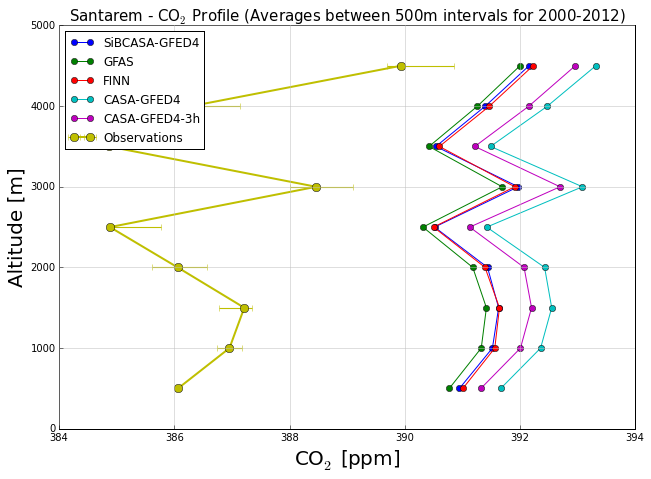

In [43]:
site = 'san'

fig = plt.figure(1,figsize=(10,8))
ax1 = fig.add_axes([0.1,0.2,0.8,0.7])
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')

altitude = [500,1000,1500,2000,2500,3000,3500,4000,4500]
legend=['SiBCASA-GFED4','GFAS','FINN','CASA-GFED4','CASA-GFED4-3h', 'Observations']
for ii,dirbf in enumerate(directories):
    print ii,dirbf
    #for y in range(minyear,maxyear):
    for fname in os.listdir(dirbf):
        if fname[4:7] == site:
            print fname
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6               
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            # indices to group per altitude 
            
            index_500 = np.where(a<500)
            index_1000 = np.where(np.logical_and(a>=500,a<1000))
            index_1500 = np.where(np.logical_and(a>=1000,a<1500))
            index_2000 = np.where(np.logical_and(a>=1500,a<2000))
            index_2500 = np.where(np.logical_and(a>=2000,a<2500))
            index_3000 = np.where(np.logical_and(a>=2500,a<3000))
            index_3500 = np.where(np.logical_and(a>=3000,a<3500))
            index_4000 = np.where(np.logical_and(a>=3500,a<4000))
            index_4500 = np.where(np.logical_and(a>=4000,a<4500))
            
            indices = [index_500,index_1000,index_1500,index_2000,index_2500,index_3000,
                       index_3500,index_4000,index_4500]
            observations = []
            simulations = []
            error_low = []
            error_high = []
            
            for i in range(len(indices)):
                observations.append((o[indices[i]]).mean())
                simulations.append((s.sum(axis=1)[indices[i]]).mean())
                error_low.append(np.median(observations) - np.percentile(observations,25.0))
                error_high.append(np.percentile(observations,75.0) - np.median(observations))
                
            if ii == 0:
                print 'SAN:SiBCASA-GFED4 RMSE = ', rmse(simulations,observations)
                
            if ii == 1:
                print 'SAN:GFAS RMSE = ', rmse(simulations,observations)
            
            if ii == 2:
                print 'SAN:FINN-GFED4 RMSE = ', rmse(simulations,observations)
            
            if ii == 3:
                print 'SAN:CASA-GFED4 RMSE = ', rmse(simulations,observations)
                
            if ii == 4:
                print 'SAN:CASA-GFED4-3h RMSE = ', rmse(simulations,observations)   
    
    ax1.plot(simulations,altitude,'-o',label=legend[ii])
ax1.errorbar(observations, altitude, xerr=np.vstack([error_low,error_high]),fmt='-o',label=legend[5],linewidth=2,markersize=8,elinewidth=1.1)
#ax1.errorbar(observations,altitude,'-',label=legend[5])
ax1.set_ylim(0,5000)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
ax1.set_title('Santarem - CO$_2$ Profile (Averages between 500m intervals for 2000-2012)',fontsize=15)
ax1.grid(True, ls='-', color='0.75') # setting the grid and the color on a grey scale
ax1.set_xlabel('CO$_2$ [ppm]',fontsize=20)
ax1.set_ylabel('Altitude [m]',fontsize=20)
ax1.legend(loc='upper left')

0 /Storage/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_att_tower-insitu_45_allvalid-79magl-instrument1.nc
(23252,) (23252,) (23252, 7) (23252,)


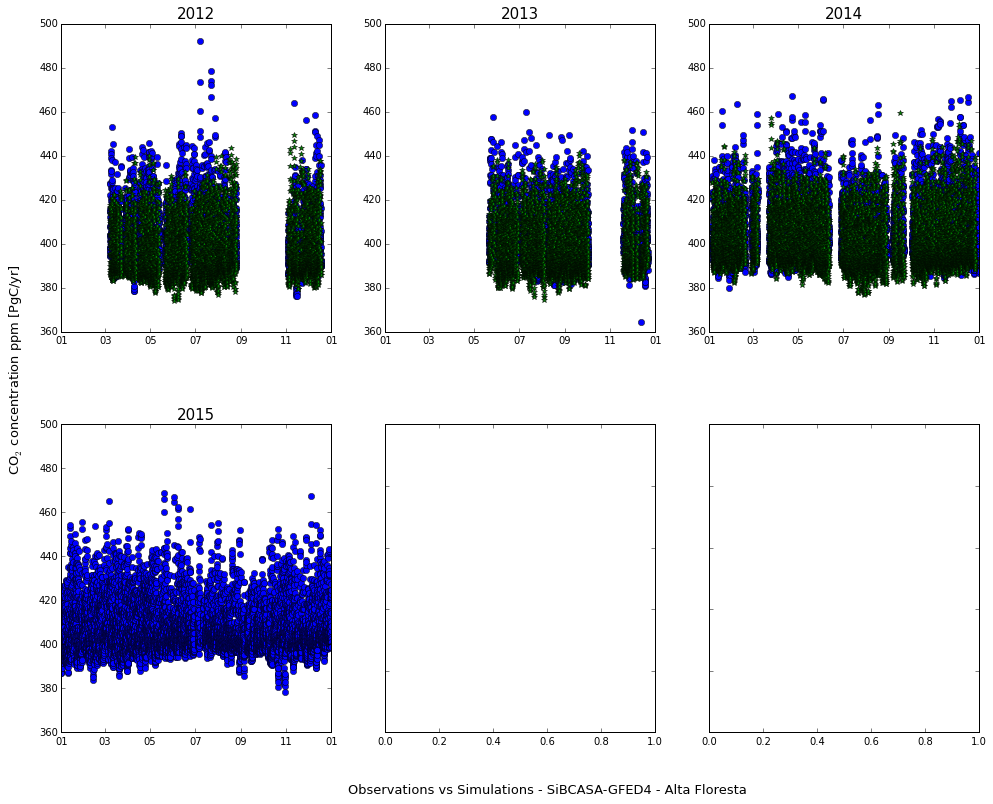

In [32]:
#################### ATTO Analysis at 79 meters with SiBCASA-GFED4

fig,axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,12))
subplots_adjust(left=0.05, bottom=0.08, right=None, top=None, wspace=None, hspace=0.3)
fig.text(0.5, 0.009,'Observations vs Simulations - SiBCASA-GFED4 - ATTO Tower', ha='center',fontsize=13)
fig.text(0, 0.5, 'CO$_2$ concentration ppm [PgC/yr]', va='center', rotation='vertical',fontsize=13)

for ii,dirbf in enumerate(directories):
    print ii,dirbf
    #for y in range(minyear,maxyear):
    for fname in os.listdir(dirbf):
        #print fname
        if fname == 'co2_att_tower-insitu_45_allvalid-79magl-instrument1.nc':
            print fname 
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            msm = f_site.variables['modelsamplesmean'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            dates = []
            for i in time:
                dates.append(dt.datetime(*i))
            dates = np.array(dates)
    print shape(dates), shape(o), shape(s), shape(a)   
    
    ax1 = plt.subplot(231)
    ax1.plot(dates,o,'o',dates,s.sum(axis=1),'*')
    xlim(dt.date(2012,1,1),dt.date(2013,1,1))
    ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
    ax1.set_title('2012',fontsize=15)

    ax2 = plt.subplot(232)
    ax2.plot(dates,o,'o',dates,s.sum(axis=1),'*')
    xlim(dt.date(2013,1,1),dt.date(2014,1,1))
    ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
    ax2.set_title('2013',fontsize=15)

    ax3 = plt.subplot(233)
    ax3.plot(dates,o,'o',dates,s.sum(axis=1),'*')
    xlim(dt.date(2014,1,1),dt.date(2015,1,1))
    ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
    ax3.set_title('2014',fontsize=15)

    ax4 = plt.subplot(234)
    ax4.plot(dates,o,'o',dates,s.sum(axis=1),'*')
    xlim(dt.date(2015,1,1),dt.date(2016,1,1))
    ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
    ax4.set_title('2015',fontsize=15)
    
    

0 /Storage/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_molefractions/
co2_att_tower-insitu_45_allvalid-809magl-instrument1.nc
(23252,) (23252,) (23252, 7) (23252,)


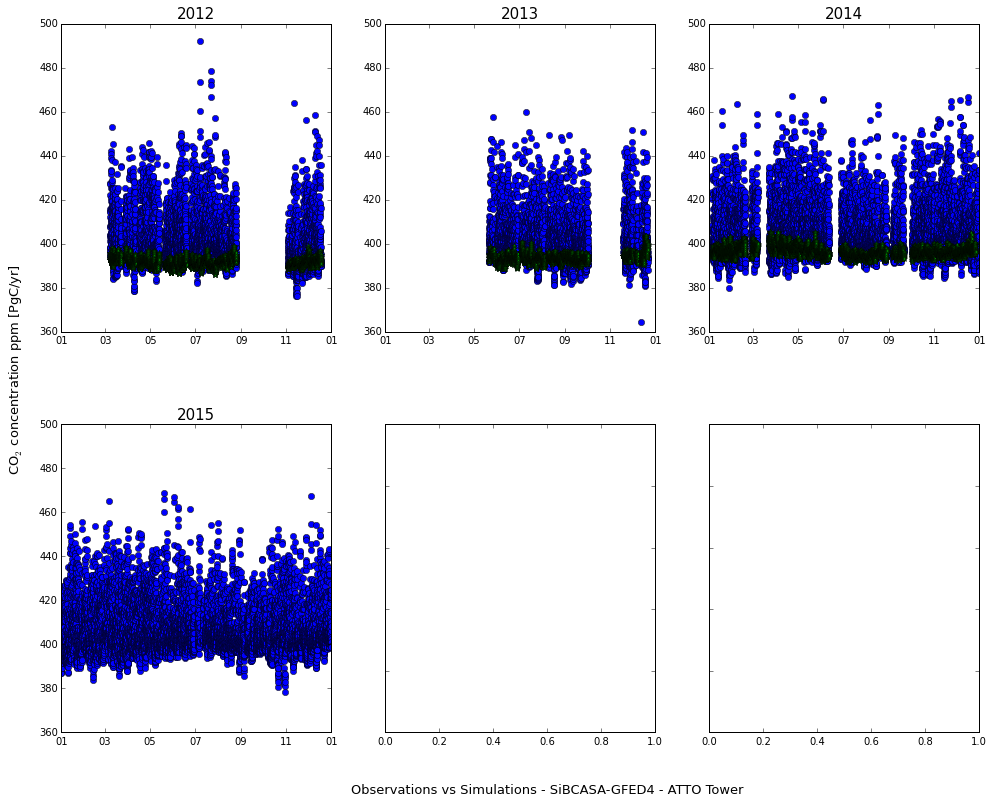

In [33]:
#################### ATTO Analysis at 679 meters with SiBCASA-GFED4

fig,axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,12))
subplots_adjust(left=0.05, bottom=0.08, right=None, top=None, wspace=None, hspace=0.3)
fig.text(0.5, 0.009,'Observations vs Simulations - SiBCASA-GFED4 - ATTO Tower', ha='center',fontsize=13)
fig.text(0, 0.5, 'CO$_2$ concentration ppm [PgC/yr]', va='center', rotation='vertical',fontsize=13)

for ii,dirbf in enumerate(directories):
    print ii,dirbf
    #for y in range(minyear,maxyear):
    for fname in os.listdir(dirbf):
        #print fname
        if fname == 'co2_att_tower-insitu_45_allvalid-809magl-instrument1.nc':
            print fname 
            f_site = cdf.Dataset(dirbf+fname)
            o = f_site.variables['value'][:]*1e6
            s = f_site.variables['modelsamplesensemble'][:]*1e6
            msm = f_site.variables['modelsamplesmean'][:]*1e6
            a = f_site.variables['altitude'][:]
            time = f_site.variables['time_components'][:]
            dates = []
            for i in time:
                dates.append(dt.datetime(*i))
            dates = np.array(dates)
    print shape(dates), shape(o), shape(s), shape(a)   
    
    ax1 = plt.subplot(231)
    ax1.plot(dates,o,'o',dates,s.sum(axis=1),'*')
    xlim(dt.date(2012,1,1),dt.date(2013,1,1))
    ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
    ax1.set_title('2012',fontsize=15)

    ax2 = plt.subplot(232)
    ax2.plot(dates,o,'o',dates,s.sum(axis=1),'*')
    xlim(dt.date(2013,1,1),dt.date(2014,1,1))
    ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
    ax2.set_title('2013',fontsize=15)

    ax3 = plt.subplot(233)
    ax3.plot(dates,o,'o',dates,s.sum(axis=1),'*')
    xlim(dt.date(2014,1,1),dt.date(2015,1,1))
    ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
    ax3.set_title('2014',fontsize=15)

    ax4 = plt.subplot(234)
    ax4.plot(dates,o,'o',dates,s.sum(axis=1),'*')
    xlim(dt.date(2015,1,1),dt.date(2016,1,1))
    ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m'))
    ax4.set_title('2015',fontsize=15)
    
    

In [10]:
bio = f2.variables['bio_flux_opt'][:]
ff = f2.variables['fossil_flux_imp'][:]
fire = f2.variables['fire_flux_imp'][:]

print shape(bio), shape(ff), type(bio), type(ff)

(1, 180, 360) (1, 180, 360) <type 'numpy.ndarray'> <type 'numpy.ndarray'>


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


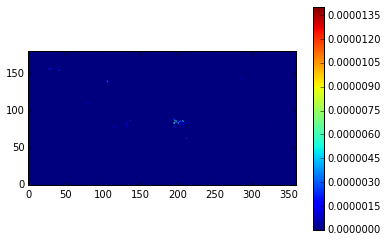

In [11]:
imshow(fire[0,:,:])
colorbar()
plt.gca().invert_yaxis()

In [12]:
f = cdf.Dataset('/Storage/CO2/botia/run1_sibcasa_gfed4_optbg/analysis/data_amazon_yearly/amazon_fluxes.2010.nc')


In [13]:
value = f.variables['fire_flux_imp'][:]*12/1e15*365*86400
value

array([[ 0.53683061]])